In [1]:
# Cell 1: Imports and global parameters
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Global parameters
SR = 22050               # Sampling rate (Hz)
DURATION = 3             # Duration (seconds) to load from each file
FIXED_LENGTH = SR * DURATION  # Fixed number of samples for each audio file
N_MFCC = 40              # Number of MFCCs to extract
MAX_PAD_LEN = 130        # Maximum number of time frames for MFCC extraction

# Directories (change these to your actual directories)
clean_dir = 'D:/projects/sound_ML/data/clean_testset_wav'
noisy_dir = 'D:/projects/sound_ML/data/noisy_testset_wav'


In [2]:
# Cell 2: Audio Preprocessing Functions

def load_audio(file_path, sr=SR, duration=DURATION):
    """
    Load an audio file and pad/truncate to a fixed length.
    """
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    if len(y) < FIXED_LENGTH:
        y = np.pad(y, (0, FIXED_LENGTH - len(y)), mode='constant')
    else:
        y = y[:FIXED_LENGTH]
    return y

def extract_mfcc(y, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    """
    Extract MFCC features from an audio signal.
    Returns an array of shape (n_mfcc, max_pad_len).
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc


In [ ]:
# Cell 3: Load file paths and build dataset arrays

# Get lists of file paths
clean_files = glob.glob(os.path.join(clean_dir, '*.wav'))
noisy_files = glob.glob(os.path.join(noisy_dir, '*.wav'))

print(f"Found {len(clean_files)} clean files.")
print(f"Found {len(noisy_files)} noisy files.")

# Build lists for features (X) and labels (y)
X = []  # MFCC features
y = []  # Labels: 0 for clean, 1 for noisy

# Process clean files
for file in clean_files:
    audio = load_audio(file)
    if audio is not None:
        mfcc = extract_mfcc(audio)
        X.append(mfcc)
        y.append(0)

# Process noisy files
for file in noisy_files:
    audio = load_audio(file)
    count = 1 
    if audio is not None:
        mfcc = extract_mfcc(audio)
        X.append(mfcc)
        y.append(1)
        print(f'File {count} preprocessed successfully.')
        count+=1

X = np.array(X)  # shape: (num_samples, n_mfcc, max_pad_len)
y = np.array(y)

print("Dataset shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# For PyTorch, we want channels-first. Convert X from (num_samples, n_mfcc, max_pad_len)
# to (num_samples, 1, n_mfcc, max_pad_len)
X = np.expand_dims(X, axis=1)
print("X shape after adding channel dimension:", X.shape)


Found 824 clean files.
Found 824 noisy files.
Dataset shapes:
X shape: (1648, 40, 130)
y shape: (1648,)
X shape after adding channel dimension: (1648, 1, 40, 130)


In [4]:
# Cell 4: Create PyTorch Dataset and DataLoader

class AudioDataset(Dataset):
    def __init__(self, X, y):
        # X is expected shape: (num_samples, 1, n_mfcc, max_pad_len)
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Create Datasets and DataLoaders
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Training set shape: (1318, 1, 40, 130)
Validation set shape: (330, 1, 40, 130)


In [5]:
# Cell 5: Build the CNN Model in PyTorch

class CNNClassifier(nn.Module):
    def __init__(self, input_shape):
        super(CNNClassifier, self).__init__()
        # input_shape: (1, n_mfcc, max_pad_len)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # -> (16, n_mfcc, max_pad_len)
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (16, n_mfcc/2, max_pad_len/2)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # -> (32, n_mfcc/2, max_pad_len/2)
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> (32, n_mfcc/4, max_pad_len/4)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> (64, n_mfcc/4, max_pad_len/4)
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> (64, n_mfcc/8, max_pad_len/8)
        )
        # Calculate flattened feature size
        # Assume n_mfcc and max_pad_len are divisible by 8.
        self.flatten_size = 64 * (input_shape[1] // 8) * (input_shape[2] // 8)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Binary classification: noisy vs. clean
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

input_shape = X_train.shape[1:]  # (1, n_mfcc, max_pad_len)
model = CNNClassifier(input_shape)
print(model)


CNNClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [6]:
# Cell 6: Training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).unsqueeze(1)  # shape: (batch_size, 1)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).unsqueeze(1)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_X.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    val_loss = running_loss / len(val_dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, " +
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/30: Train Loss: 0.6065, Train Acc: 0.7405, Val Loss: 0.1495, Val Acc: 0.9424
Epoch 2/30: Train Loss: 0.1047, Train Acc: 0.9651, Val Loss: 0.0838, Val Acc: 0.9697
Epoch 3/30: Train Loss: 0.0678, Train Acc: 0.9772, Val Loss: 0.1063, Val Acc: 0.9545
Epoch 4/30: Train Loss: 0.0872, Train Acc: 0.9666, Val Loss: 0.0770, Val Acc: 0.9667
Epoch 5/30: Train Loss: 0.0626, Train Acc: 0.9750, Val Loss: 0.0566, Val Acc: 0.9788
Epoch 6/30: Train Loss: 0.0398, Train Acc: 0.9841, Val Loss: 0.0583, Val Acc: 0.9758
Epoch 7/30: Train Loss: 0.0339, Train Acc: 0.9924, Val Loss: 0.0504, Val Acc: 0.9788
Epoch 8/30: Train Loss: 0.0226, Train Acc: 0.9917, Val Loss: 0.0954, Val Acc: 0.9606
Epoch 9/30: Train Loss: 0.0137, Train Acc: 0.9939, Val Loss: 0.5919, Val Acc: 0.8697
Epoch 10/30: Train Loss: 0.0898, Train Acc: 0.9734, Val Loss: 0.0519, Val Acc: 0.9788
Epoch 11/30: Train Loss: 0.0331, Train Acc: 0.9879, Val Loss: 0.1811, Val Acc: 0.9333
Epoch 12/30: Train Loss: 0.0119, Train Acc: 0.9954, Val Loss: 0

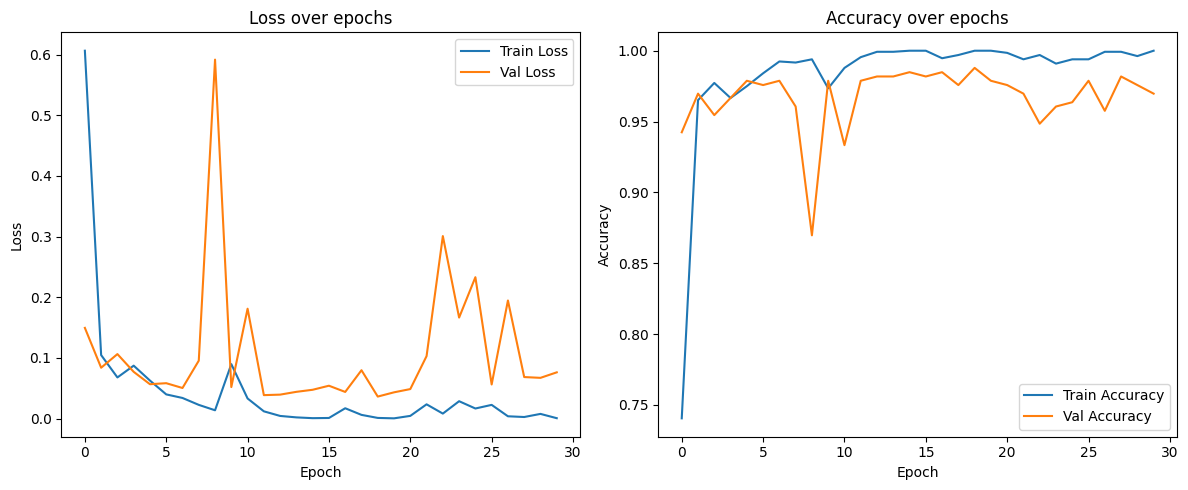

In [7]:
# Cell 7: Plot training history

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Cell 8: Inference functions

def inference_preprocess(file_path, sr=SR):
    """
    Load an audio file and split it into segments of FIXED_LENGTH samples.
    Returns a numpy array of MFCC batches with shape (num_segments, 1, n_mfcc, max_pad_len).
    """
    audio = load_audio(file_path, sr=sr)
    if audio is None:
        return None
    audio_len = len(audio)
    segments = []
    # Use non-overlapping segments
    for i in range(0, audio_len - FIXED_LENGTH + 1, FIXED_LENGTH):
        segment = audio[i:i+FIXED_LENGTH]
        mfcc = extract_mfcc(segment)
        mfcc = mfcc[..., np.newaxis]  # shape: (n_mfcc, max_pad_len, 1)
        segments.append(mfcc)
    # Handle leftover (pad if necessary)
    if audio_len % FIXED_LENGTH != 0:
        segment = audio[-FIXED_LENGTH:]
        mfcc = extract_mfcc(segment)
        mfcc = mfcc[..., np.newaxis]
        segments.append(mfcc)
    
    segments = np.stack(segments)
    # Rearrange to channels-first: (num_segments, 1, n_mfcc, max_pad_len)
    segments = np.transpose(segments, (0, 3, 1, 2))
    return segments

def predict_audio(file_path, model, sr=SR):
    """
    Run inference on a single audio file.
    Returns the predicted class for each segment and overall majority vote.
    """
    segments = inference_preprocess(file_path, sr)
    if segments is None:
        return None, None
    segments = torch.from_numpy(segments).float().to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(segments)  # shape: (num_segments, 1)
    predictions = predictions.cpu().numpy().flatten()
    predicted_labels = (predictions > 0.5).astype(int)
    # Overall decision via majority vote
    final_prediction = np.round(np.mean(predicted_labels)).astype(int)
    return final_prediction, predicted_labels

# Example inference:
test_file = clean_files[0] if len(clean_files) > 0 else None
if test_file:
    final_pred, batch_preds = predict_audio(test_file, model)
    print(f"Overall prediction for {os.path.basename(test_file)}: {'Noisy' if final_pred==1 else 'Clean'}")
    print("Batch predictions:", batch_preds)


Overall prediction for p232_001.wav: Clean
Batch predictions: [0]
